In [1]:
#Neural network program using Long Short Term Memory (LSTM) to predict future stock prices

In [2]:
#Download Libraries (Downloads libraries to your computer automatically)
'''import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install beautifulsoup4
!{sys.executable} -m pip install datetime'''

#Import Libraries (Import libraries to this program)
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import seaborn as sns
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [3]:
#Gather current date
ticker =['AAPL','TSLA','LHX','BILI','MSFT','SNAP']
today = datetime.today().strftime('%Y-%m-%d')
six_months_ago =  datetime.today() - timedelta(days = 252/2)
two_years_ago =  datetime.today() - timedelta(days = 252*2)
start_date = "2015-1-1"
future_date = datetime.today() + timedelta(days = 252)
future_date = future_date.strftime('%Y-%m-%d')
#data = pd.DataFrame()

In [4]:
#Function to import stock data
def import_stock_data(tickers, start, end):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = web.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = web.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [5]:
#List and plot stocks to research

#stocks_df = import_stock_data(ticker, start_date, today)
'''print(future_date)
plt.plot(stocks_df)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price', fontsize = 16)
plt.show()'''

#Get the number of rows and columns
#stocks_df.shape

#Convert stock data to numpy array
#clean_stocks_df = stocks_df.dropna()
#dataset = clean_stocks_df.values
#print(stocks_df[stocks_df.columns[2]])

"print(future_date)\nplt.plot(stocks_df)\nplt.xlabel('Date', fontsize = 16)\nplt.ylabel('Price', fontsize = 16)\nplt.show()"

In [6]:
#30 Day Simple Moving Average
def SMA_20(data):
    SMA_20 = data.rolling(window = 20).mean()
    SMA_20 = SMA_20.dropna()
    SMA_20 = pd.DataFrame(SMA_20)
    return SMA_20

#100 Day Simple Moving Average
def SMA_100(data):
    SMA_100 = data.rolling(window = 100).mean()
    SMA_100 = SMA_100.dropna()
    SMA_100 = pd.DataFrame(SMA_100)
    return SMA_100


In [7]:
#Function for the Long Short-Term Memory artificital recurrent neural network
def LSTM_model(df, batchsize, iterations, plot_prediction=True):
    clean_stocks_df = df.dropna()
    dataset = clean_stocks_df.values.reshape(-1,1)
    print(dataset)
    
    #Get 80% of the number of rows to train the model
    training_data_len = math.ceil(len(dataset) * .8)
    
    #Scale the data to apply preprocessing transformers to the imported data before implementing in neural network
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    #Create training dataset
    train_data = scaled_data[0:training_data_len , :]
    
    #Split the data into x_train and y_train data sets
    x_train = [] #x_train is independent variables, so date in this case
    y_train = [] #y_train is dependent variables, so price in this case
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])
        
    #Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Train the model
    model.fit(x_train, y_train, batch_size=batchsize, epochs=iterations)
    
    #Create the testing data set
    test_data = scaled_data[training_data_len - 60:, :]

    #Create the data sets x_test and y_test to verify data
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_test = np.array(x_test)

    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    #Get the Root Mean Squre Error (RMSE)
    rmse = np.sqrt(np.mean(predictions-y_test)**2)
    
    #### Future Predictions #####
    #Create the data sets x_test and y_test to predict future data
    x_future = []
    y_future = dataset[training_data_len:, :]
    for i in range(60, len(test_data)+252):
        x_future.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_future = np.array(x_future)

    #Reshape the data
    x_future = np.reshape(x_future, (x_future.shape[0], x_future.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_future)
    predictions = scaler.inverse_transform(predictions)
    
    #Plot the data
    if plot_prediction== True:
        train = stocks_df[:training_data_len]
        valid = stocks_df[training_data_len:]
        valid['Predictions']= predictions
        plt.title('Model')
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Close Price USD ($)', fontsize=16)
        plt.plot(train)
        plt.plot(valid)
        plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
        plt.show()
    
    return predictions, rmse, training_data_len


In [8]:
#### Error with prediction values in graph. Index of 'Prediction' values does not have a designated date ####
#### Need to index the 'Prediction' values to match the index of 'Valid' values ###

#Show the valid and predicted prices
'''for i in range(0,len(stocks_df.columns)):
    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["Predictions"]
    print("Predictions:",predictions)
    train = stocks_df[stocks_df.columns[i]][:training_data_len]
    train = pd.DataFrame(train)
    train.columns = ["Train"]
    valid = stocks_df[stocks_df.columns[i]][training_data_len:]
    valid = pd.DataFrame(valid)
    valid.columns = ["Valid"]
    print("Train:",train)
    print("Valid:", valid)
    valid['Predictions']= predictions
    plt.title('Model')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close Price USD ($)', fontsize=16)
    plt.plot(train)
    plt.plot(valid)
    plt.plot(predictions)
    plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
    plt.show()
    print(ticker[i])
    print(rmse)'''

'for i in range(0,len(stocks_df.columns)):\n    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)\n    predictions = pd.DataFrame(predictions)\n    predictions.columns = ["Predictions"]\n    print("Predictions:",predictions)\n    train = stocks_df[stocks_df.columns[i]][:training_data_len]\n    train = pd.DataFrame(train)\n    train.columns = ["Train"]\n    valid = stocks_df[stocks_df.columns[i]][training_data_len:]\n    valid = pd.DataFrame(valid)\n    valid.columns = ["Valid"]\n    print("Train:",train)\n    print("Valid:", valid)\n    valid[\'Predictions\']= predictions\n    plt.title(\'Model\')\n    plt.xlabel(\'Date\', fontsize=16)\n    plt.ylabel(\'Close Price USD ($)\', fontsize=16)\n    plt.plot(train)\n    plt.plot(valid)\n    plt.plot(predictions)\n    plt.legend([\'Train\', \'Validation\',\'Predictions\'], loc=\'upper left\')\n    plt.show()\n    print(ticker[i])\n    print(rmse)'

In [9]:
'''predictions_df= pd.DataFrame(predictions)
SMA_20_df = SMA_20(predictions_df)
#print(SMA_20_df)

SMA_100_df = SMA_100(predictions_df)
#print(SMA_100_df)

plt.plot(predictions_df)
plt.plot(SMA_20_df)
plt.plot(SMA_100_df)
plt.title('SMA Return Prediction')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')
plt.show()'''

"predictions_df= pd.DataFrame(predictions)\nSMA_20_df = SMA_20(predictions_df)\n#print(SMA_20_df)\n\nSMA_100_df = SMA_100(predictions_df)\n#print(SMA_100_df)\n\nplt.plot(predictions_df)\nplt.plot(SMA_20_df)\nplt.plot(SMA_100_df)\nplt.title('SMA Return Prediction')\nplt.xlabel('Date', fontsize=16)\nplt.ylabel('Close Price USD ($)', fontsize=16)\nplt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')\nplt.show()"

In [10]:
#Program to use the three moving average crossover strategy to determine when to buy and sell stock
stocks_df = import_stock_data(ticker, start_date, today)
'''plt.title(ticker)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(stocks_df)
plt.show()'''

"plt.title(ticker)\nplt.xlabel('Date', fontsize=16)\nplt.ylabel('Price', fontsize=16)\nplt.plot(stocks_df)\nplt.show()"

In [11]:
#Calculate the three moving averages

#Gather stock data
def calculate_EMA(ticker,plot=True):
    stocks_df = import_stock_data(ticker, two_years_ago, today)
    #print(stocks_df)
    #print(stocks_df[i])
    ShortEMA = 0
    MiddleEMA = 0
    LongEMA = 0
    #Short/Fast Exponential Moving Average (5 Day EMA)
    ShortEMA = stocks_df.ewm(span=5, adjust=False).mean()

    #Middle/Medium Exponential Moving Average (21 Day EMA)
    MiddleEMA = stocks_df.ewm(span=21, adjust=False).mean()

    #Long/Slow Exponential Moving Average (63 Day EMA)
    LongEMA = stocks_df.ewm(span=63, adjust = False).mean()

    '''#Visualize Closing Price and Exponential Moving Averages
    plt.title(ticker)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.plot(stocks_df, color='blue')
    plt.plot(ShortEMA, color='red')
    plt.plot(MiddleEMA, color='orange')
    plt.plot(LongEMA, color='green')
    plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
    plt.show()'''

    #Add EMA to the dataset
    stocks_df['Short EMA']=ShortEMA
    stocks_df['Middle EMA']=MiddleEMA
    stocks_df['Long EMA']=LongEMA
    #print(stocks_df)
    
    stocks_df['Buy'], stocks_df['Sell'] = get_EMA_signal(stocks_df, ShortEMA, MiddleEMA, LongEMA, plot=True)
    
    if plot == True:
        plt.figure(figsize=(11,4))
        plt.title(ticker)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.plot(stocks_df[ticker], color='blue', alpha = 0.4)
        plt.plot(ShortEMA, color='red', alpha = 0.4)
        plt.plot(MiddleEMA, color='orange',alpha = 0.4)
        plt.plot(LongEMA, color='green', alpha = 0.4)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
        plt.show()

    '''#Show Data
    stocks_df = pd.DataFrame(stocks_df)
    print(stocks_df)
    stocks_df.iloc[0,0]
    stocks_df.iloc[1,1]
    #stocks_df[ticker][0,2]'''

    #Buy_list_df = pd.DataFrame(Buy_list)
    #Buy_list_df = Buy_list_df.dropna()
    #Buy_sum = Buy_list_df.sum()
    #Sell_list_df = pd.DataFrame(Sell_list)
    #Sell_list_df = Sell_list_df.dropna()
    #Sell_sum = Sell_list_df.sum()  
    
    return stocks_df

In [12]:
#Function to indicate when to buy and sell stocks
def get_EMA_signal(data, ShortEMA, MiddleEMA, LongEMA, plot=True):
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False
    #print(data)
    #print(data[ticker])
    #print(len(data))
    
    for i in range(0, len(data)):
        
        #Buy when Middle EMA crosses below Long EMA and Short EMA crosses Middle EMA
        if data.iloc[i,2] < data.iloc[i,3] and data.iloc[i,1] < data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_short = True
        
        #Sell when Short EMA crosses Middle EMA
        elif flag_short == True and data.iloc[i,1] > data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_short = False
            
        #Buy when Long EMA crosses below Middle EMA and Middle EMA crosses Short EMA
        elif data.iloc[i,2] > data.iloc[i,3] and data.iloc[i,1] > data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_long = True
        
        #Sell when Middle EMA crosses Short EMA
        elif flag_long == True and data.iloc[i,1] < data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_long = False
            
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
        
    #Plot data
    price_list=[]
    ShortEMA_list=[]
    MiddleEMA_list=[]
    LongEMA_list=[]
    for i in range(0,len(data)):
        price_list.append(data.iloc[i,0])
        ShortEMA_list.append(data.iloc[i,1])
        MiddleEMA_list.append(data.iloc[i,2])
        LongEMA_list.append(data.iloc[i,3])
     
        #stocks_df.values
        #print(stocks_df)
            
    return buy_list, sell_list 

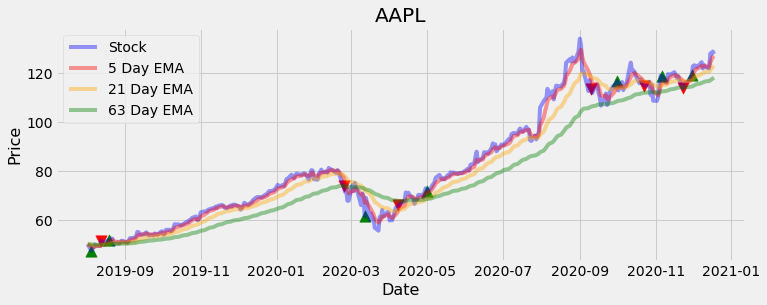

AAPL Performance
          Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   47.596859   51.640156      4.043297   8.494882        4.043297
1   51.981182   74.082146     22.100964  42.517239       26.144260
2   61.672176   66.104485      4.432308   7.186885       30.576569
3   71.818787  113.294540     41.475754  57.750563       72.052322
4  116.588860  114.841873     -1.746986  -1.498416       70.305336
5  118.690002  113.849998     -4.840004  -4.077853       65.465332

Total Profit: $ 65.47
Total ROI: 13.98 %
Estimated Yearly ROI: 6.99 %
Expected Profits for Buy and Hold Strategy: $ 66.25
Expected ROI for Buy and Hold Strategy: 139.2 %

POOR Performance: Annual Alpha = -3.01 %


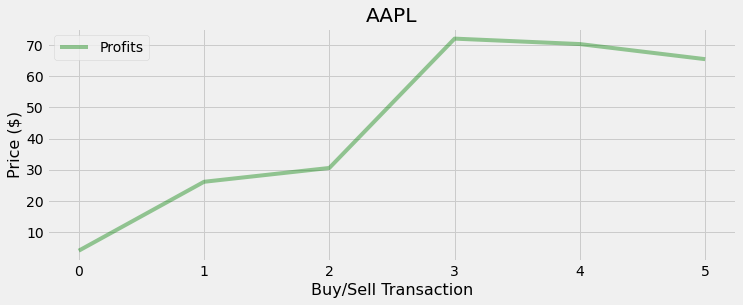

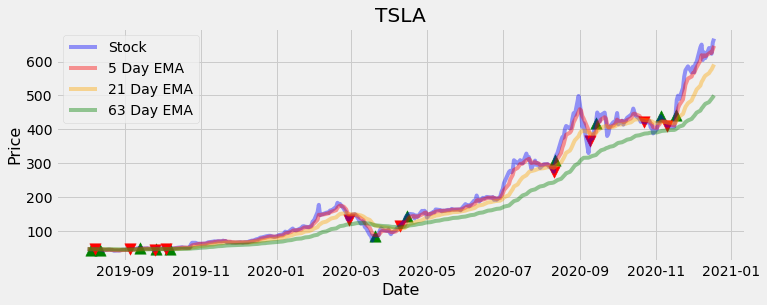

TSLA Performance
          Buy        Sell  Trade Profit   Trade ROI  Profit Balance
0   45.664001   47.660000      1.995998    4.371054        1.995998
1   45.801998   45.916000      0.114002    0.248902        2.110001
2   49.040001   45.740002     -3.299999   -6.729199       -1.189999
3   48.512001   46.285999     -2.226002   -4.588559       -3.416000
4   47.543999  133.598007     86.054008  180.998677       82.638008
5   85.505997  114.599998     29.094002   34.025686      111.732010
6  145.966003  274.877991    128.911987   88.316446      240.643997
7  310.951996  366.279999     55.328003   17.793101      295.972000
8  419.619995  420.630005      1.010010    0.240696      296.982010
9  438.089996  410.359985    -27.730011   -6.329752      269.251999

Total Profit: $ 269.25
Total ROI: 16.45 %
Estimated Yearly ROI: 8.23 %
Expected Profits for Buy and Hold Strategy: $ 364.7
Expected ROI for Buy and Hold Strategy: 798.65 %

POOR Performance: Annual Alpha = -1.77 %


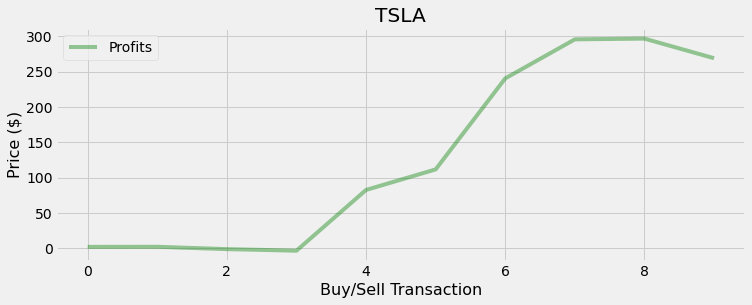

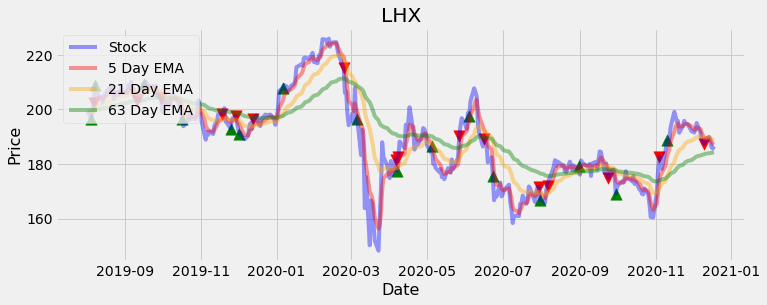

LHX Performance
           Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   196.409225  202.329117      5.919891   3.014060        5.919891
1   209.146225  203.401825     -5.744400  -2.746595        0.175491
2   209.450424  204.204361     -5.246063  -2.504680       -5.070572
3   196.668060  198.429794      1.761734   0.895791       -3.308838
4   193.019501  197.538223      4.518723   2.341070        1.209885
5   190.838715  196.644318      5.805603   3.042152        7.015488
6   207.980499  215.190857      7.210358   3.466843       14.225845
7   196.398727  181.569443    -14.829285  -7.550601       -0.603439
8   177.523605  182.753586      5.229980   2.946076        4.626541
9   186.503387  190.401230      3.897842   2.089958        8.524384
10  197.687454  189.293564     -8.393890  -4.246041        0.130493
11  175.657227  171.673325     -3.983902  -2.267998       -3.853409
12  166.817383  172.109390      5.292007   3.172336        1.438599
13  179.115860  174.979218     -

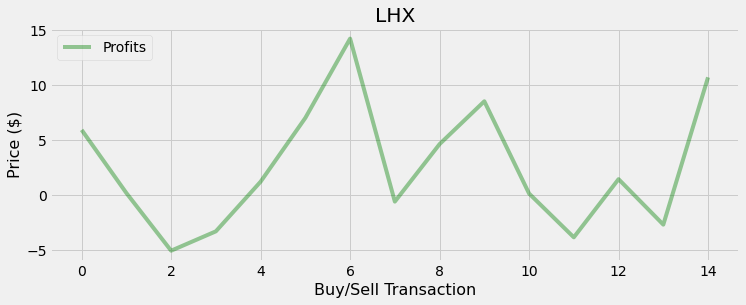

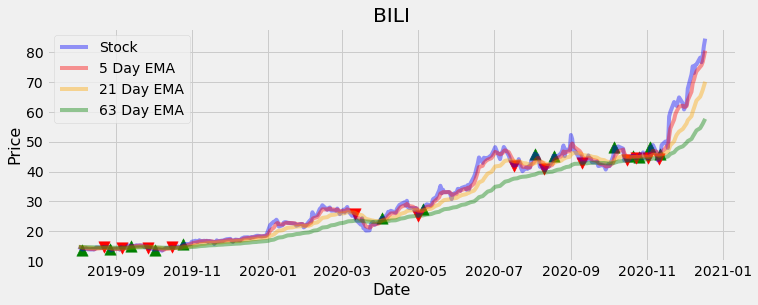

BILI Performance
          Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0   13.810000  14.700000      0.889999   6.444601        0.889999
1   13.920000  14.460000      0.540000   3.879310        1.429999
2   15.060000  14.330000     -0.730000  -4.847281        0.699999
3   13.800000  14.560000      0.760000   5.507248        1.459999
4   15.520000  25.670000     10.150000  65.399480       11.609999
5   24.420000  25.139999      0.719999   2.948400       12.329998
6   27.510000  41.900002     14.390001  52.308256       26.719999
7   46.029999  41.000000     -5.029999 -10.927654       21.690001
8   45.310001  42.970001     -2.340000  -5.164423       19.350000
9   48.169998  43.820000     -4.349998  -9.030514       15.000002
10  45.160000  44.439999     -0.720001  -1.594334       14.280001
11  45.000000  44.459999     -0.540001  -1.200002       13.740000
12  48.160000  44.200001     -3.959999  -8.222589        9.780001

Total Profit: $ 9.78
Total ROI: 2.43 %
Estimated Yearly RO

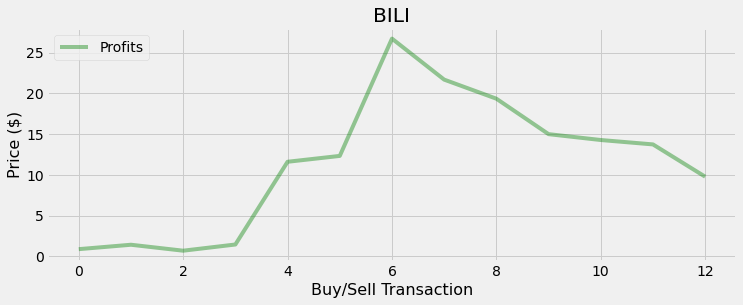

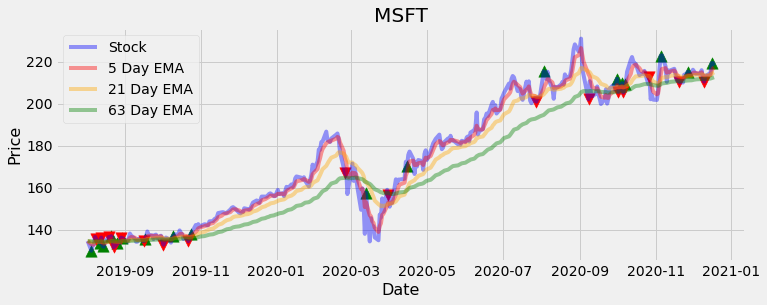

MSFT Performance
           Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   129.947739  135.353622      5.405884   4.160045        5.405884
1   133.466446  136.228409      2.761963   2.069406        8.167847
2   132.125946  136.494659      4.368713   3.306477       12.536560
3   136.869385  131.544113     -5.325272  -3.890769        7.211288
4   133.575623  136.208664      2.633041   1.971199        9.844330
5   135.952271  134.443436     -1.508835  -1.109827        8.335495
6   135.488770  132.786682     -2.702087  -1.994326        5.633408
7   137.175110  134.482895     -2.692215  -1.962612        2.941193
8   138.003479  166.762451     28.758972  20.839310       31.700165
9   157.594345  156.483047     -1.111298  -0.705163       30.588867
10  170.542801  201.006592     30.463791  17.862842       61.052658
11  215.453751  202.130814    -13.322937  -6.183664       47.729721
12  211.905228  205.651596     -6.253632  -2.951146       41.476089
13  209.830658  205.372330     

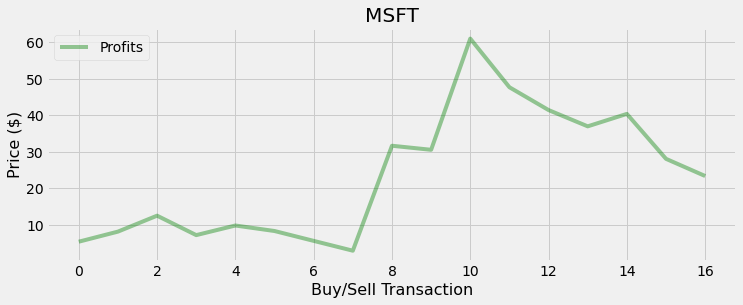

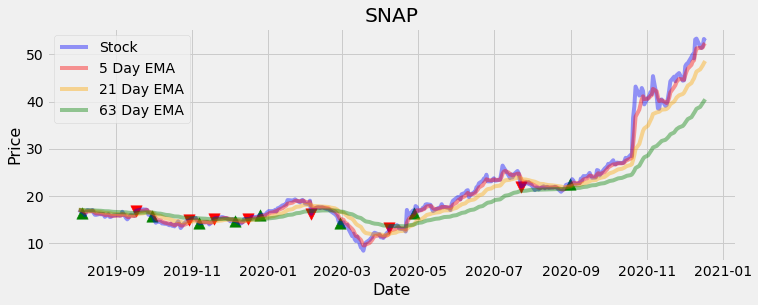

SNAP Performance
         Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0  16.459999  16.830000      0.370001   2.247879        0.370001
1  15.800000  14.860000     -0.940001  -5.949370       -0.570000
2  14.160000  15.160000      1.000000   7.062147        0.430000
3  14.740000  15.110000      0.370000   2.510176        0.800000
4  15.970000  16.190001      0.220000   1.377585        1.020000
5  14.170000  13.220000     -0.950000  -6.704303        0.070001
6  16.410000  21.969999      5.559999  33.881776        5.630000

Total Profit: $ 5.63
Total ROI: 5.23 %
Estimated Yearly ROI: 2.61 %
Expected Profits for Buy and Hold Strategy: $ 5.51
Expected ROI for Buy and Hold Strategy: 33.48 %

POOR Performance: Annual Alpha = -7.39 %


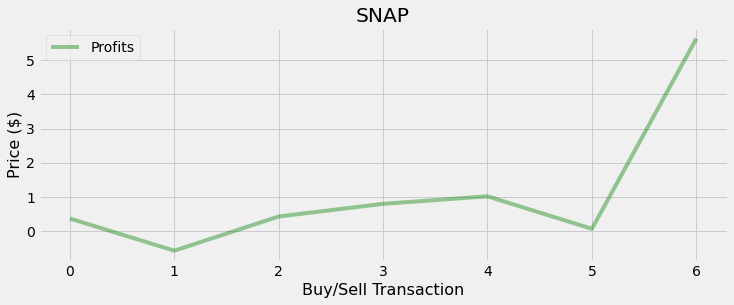

In [21]:
#Function to determine profitability and performance of trading strategy
def performance_analysis(stocks_df, ticker, plot=True):   
    date_index=[]
    for i in range(0,len(stocks_df)):
        date_index.append(stocks_df.index[i])
    stocks_df['Date Index']=date_index
    #print(stocks_df)
    
    clean_sell_df=stocks_df['Sell'].dropna()
    #print("Sell Dates:\n",clean_sell_df)
    clean_buy_df=stocks_df['Buy'].dropna()
    #print("Buy Dates:\n", clean_buy_df)
    
    prev_time = clean_buy_df.index[0] # Get initial buy time
    buy_ind = 1 # Buy index
    sell_ind = 0 # Sell index
    is_buy = False
    i = 0 # i index
    s_buy = len(clean_buy_df) # Size of buy
    s_sell = len(clean_sell_df) # Size of sell
    s = s_buy + s_sell # Size of buy and sell
    while(i < s and buy_ind < s_buy and sell_ind < s_sell):
        if is_buy: # If buy data
            if clean_buy_df.index[buy_ind] > prev_time: # Compare times, look for time after previous time
                prev_time = clean_buy_df.index[buy_ind]
                is_buy = False
            else: # Remove price if time is before previous time
                clean_buy_df.iloc[buy_ind] = np.nan
            buy_ind += 1
        else: # If sell data
            if clean_sell_df.index[sell_ind] > prev_time: # Compare times, look for time after previous time
                prev_time = clean_sell_df.index[sell_ind]
                is_buy = True
            else: # Remove price if time is before previous time
                clean_sell_df.iloc[sell_ind] = np.nan # Remove row
            sell_ind += 1
        i += 1
    
    if not is_buy and buy_ind > 0: # Don't want to end on buy, so get rid of it 
        clean_buy_df.iloc[buy_ind - 1] = np.nan
    
    for i in range(buy_ind, s_buy): # Clean up the remaining buy and sells
        clean_buy_df.iloc[i] = np.nan
    for i in range(sell_ind, s_sell):
        clean_sell_df.iloc[i] = np.nan    
        
    clean_buy_df = clean_buy_df.dropna()
    clean_sell_df = clean_sell_df.dropna()
    #print(clean_sell_df)
    
    sell_arr=clean_sell_df.to_numpy()
    buy_arr=clean_buy_df.to_numpy()
    
    buy_sell_df=pd.DataFrame()
    buy_sell_df['Buy']=buy_arr
    buy_sell_df['Sell']=sell_arr
    #print(buy_sell_df) 
    
    trade_profit=buy_sell_df['Sell'].subtract(buy_sell_df['Buy'])
    ROI=((buy_sell_df['Sell'].subtract(buy_sell_df['Buy']))/buy_sell_df['Buy'])*100

    buy_sell_df['Trade Profit']=trade_profit
    buy_sell_df['Trade ROI']=ROI

    cum_profit=buy_sell_df['Trade Profit'].cumsum()
    buy_sell_df['Profit Balance']=cum_profit
    print(ticker,"Performance")
    print(buy_sell_df)
    
    #Calculate the profits if you just bought and held the stock
    buy_hold= buy_sell_df.iloc[len(buy_sell_df)-1,1]-buy_sell_df.iloc[0,0]
    buy_hold_ROI = ((buy_sell_df.iloc[len(buy_sell_df)-1,1]-buy_sell_df.iloc[0,0])/buy_sell_df.iloc[0,0])*100

    total_profit=buy_sell_df['Trade Profit'].sum()
    print("\nTotal Profit: $", round(total_profit,2))

    buys_total=buy_sell_df['Buy'].sum()
    #print(buys_total)
    sells_total=buy_sell_df['Sell'].sum()
    #print(sells_total)
    total_ROI=((sells_total-buys_total)/buys_total)*100
    print("Total ROI:", round(total_ROI,2), "%")
    print("Estimated Yearly ROI:", round(total_ROI/2,2), "%")
    print("Expected Profits for Buy and Hold Strategy: $", round(buy_hold,2))
    print("Expected ROI for Buy and Hold Strategy:", round(buy_hold_ROI,2), "%\n")
    if (total_ROI/2) < 10:
        print("POOR Performance: Annual Alpha =", round((total_ROI/2)-10,2),"%")
    elif 10 <= (total_ROI/2) <= 15:
        print("DECENT Performance: Annual Alpha =", round((total_ROI/2)-10,2),"%")
    elif 15 < (total_ROI/2) <= 20:
        print("GOOD Performance: Annual Alpha =", round((total_ROI/2)-10,2),"%")
    elif 20 < (total_ROI/2):
        print("GREAT Performance: Annual Alpha =", round((total_ROI/2)-10,2),"%")
    
    if plot==True:
        plt.figure(figsize=(11,4))
        plt.title(ticker)
        plt.xlabel('Buy/Sell Transaction', fontsize=16)
        plt.ylabel('Price ($)', fontsize=16)
        if total_profit > 0:
            plt.plot(cum_profit, color='green', alpha = 0.4)
        elif total_profit < 0:
            plt.plot(cum_profit, color='red', alpha = 0.4)
        else:
            plt.plot(cum_profit, color='blue', alpha = 0.4)
        #plt.plot(ROI, color='green', alpha = 0.4)
        plt.legend(['Profits','ROI'], loc='upper left')
        plt.show()

    return buy_sell_df,total_profit,total_ROI

for i in ticker:
    stocks_df= calculate_EMA(i, plot=True)
    stocks_performance, analysis_profit, analysis_ROI= performance_analysis(stocks_df, i, plot=True)

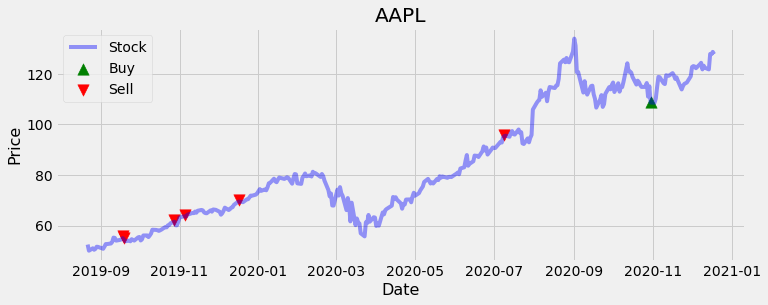

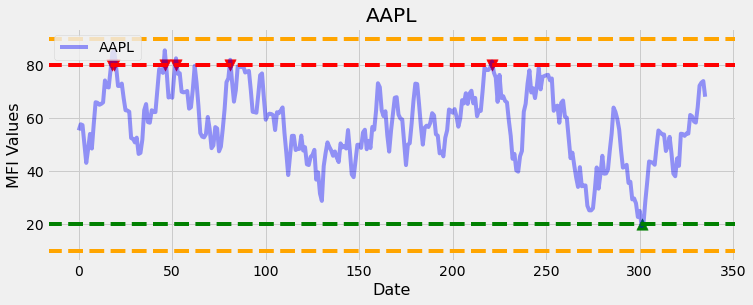

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 792x288 with 1 Axes>

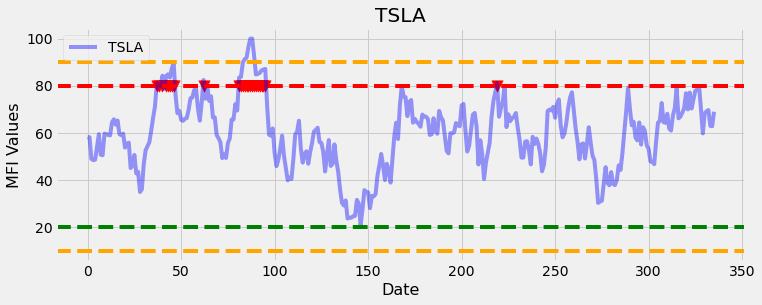

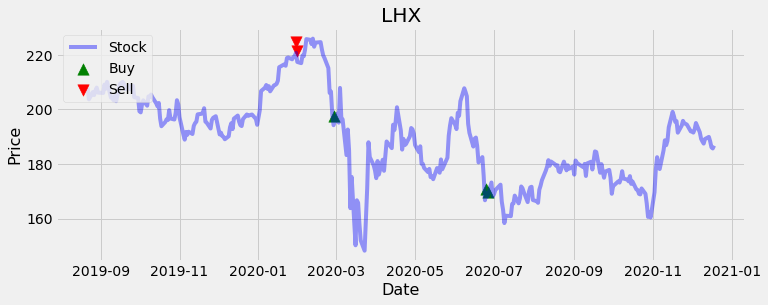

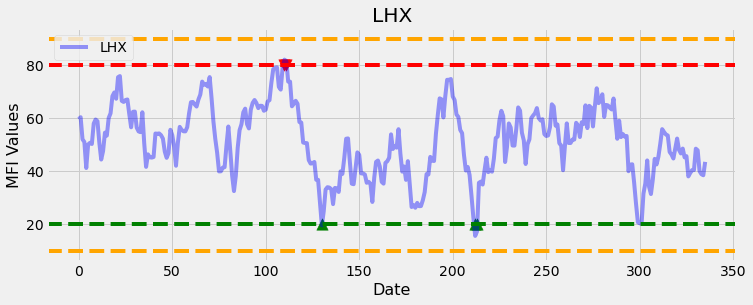

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 792x288 with 1 Axes>

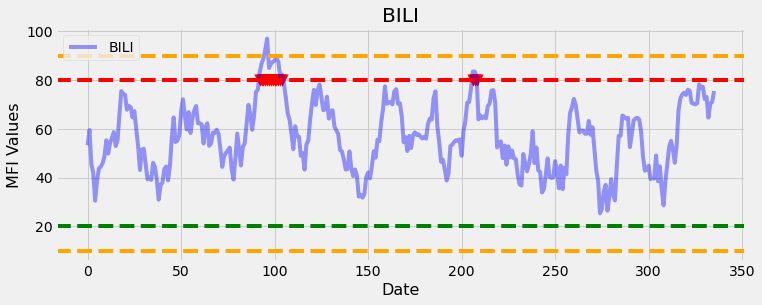

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 792x288 with 1 Axes>

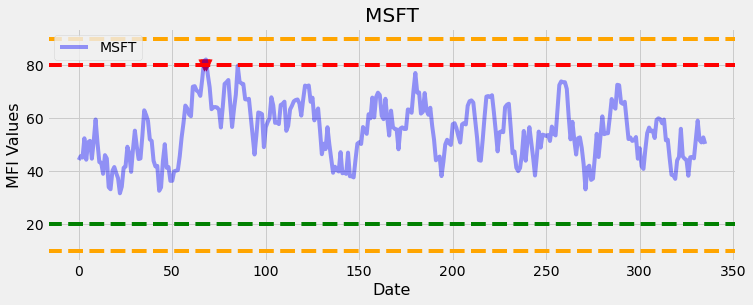

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 792x288 with 1 Axes>

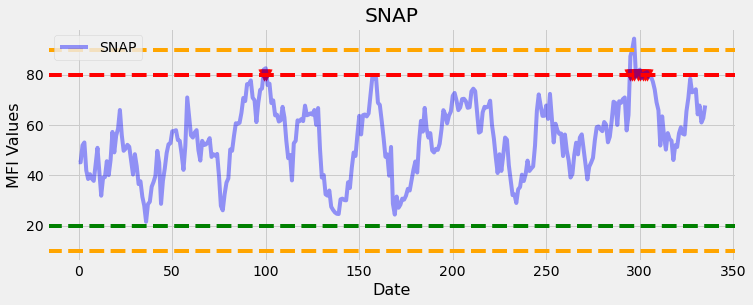

In [18]:
#Money Flow Index (MFI) Strategy - Uses Price and Volume to determine if stock is being overbought or oversold

#Create a function to get the buy and sell signals
def get_MFI_buy_sell_signals(data, high, low):
    buy_signal = []
    sell_signal = []
    buy_location = []
    sell_location = [] 
        
    for i in range(len(data['MFI'])):
        if data['MFI'][i] > high:
            buy_signal.append(np.nan)
            buy_location.append(np.nan)
            sell_signal.append(data['Close'][i])
            sell_location.append(high)
        elif data['MFI'][i] < low:
            sell_signal.append(np.nan)
            sell_location.append(np.nan)
            buy_signal.append(data['Close'][i])
            buy_location.append(low)
        else:
            sell_signal.append(np.nan)
            sell_location.append(np.nan)
            buy_signal.append(np.nan)
            buy_location.append(np.nan)
                
    return buy_signal, sell_signal, buy_location, sell_location

def calculate_MFI(ticker, plot=True):
    df= web.DataReader(ticker, data_source='yahoo', start=two_years_ago)
    
    #Calculate the typical price
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    #print('Typical Price\n',typical_price)
    
    #Get the period
    period = 14
    
    #Calculate the money flow
    money_flow = typical_price * df['Volume']
    #print('Money Flow\n',money_flow)
    
    #Get all of the positive and negative money flows
    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
        else:
            positive_flow.append(0)
            negative_flow.append(0)
        
    #Get all the positive and negative money flows within the time period
    positive_mf = []
    negative_mf = []
    
    for i in range(period-1, len(positive_flow)):
        positive_mf.append(sum(positive_flow[i+1-period : i+1]))
    for i in range(period-1, len(negative_flow)):
        negative_mf.append(sum(negative_flow[i+1-period : i+1]))
        
    #Calculat the Money Flow Index (MFI)
    MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    #print(MFI)
    
    #Create a new data Frame
    new_df = pd.DataFrame()
    new_df = df[period:]
    new_df["MFI"]= MFI
    #print(t,new_df)
        
    #Add new buy and sell columns
    new_df['Buy'] = get_MFI_buy_sell_signals(new_df,80,20)[0]
    new_df['Sell'] = get_MFI_buy_sell_signals(new_df,80,20)[1]
    indicator_df = pd.DataFrame()
    indicator_df['Buy'] = get_MFI_buy_sell_signals(new_df,80,20)[2]
    indicator_df['Sell'] = get_MFI_buy_sell_signals(new_df,80,20)[3]
    #indicator_df.dropna()
    #print(indicator_df)
    #print(new_df['Buy'])
    #print(new_df['Sell'])       
    
    #Show the data
    if plot==True:
        #print(t, new_df)
        plt.figure(figsize=(11,4))
        plt.title(t)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.scatter(new_df.index, new_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(new_df.index, new_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.plot(new_df['Adj Close'], color='blue', alpha = 0.4)
        plt.legend(['Stock','Buy','Sell'], loc='upper left')
        plt.show()
    
        #Plot the MFI
        MFI_df = pd.DataFrame()
        MFI_df["MFI"] = MFI
        plt.figure(figsize=(11,4))
        plt.title(t)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('MFI Values', fontsize=16)
        plt.plot(MFI_df['MFI'], color='blue', alpha = 0.4)
        plt.axhline(10, linestyle= '--', color = 'orange')
        plt.axhline(20, linestyle= '--', color = 'green')
        plt.axhline(80, linestyle= '--', color = 'red')
        plt.axhline(90, linestyle= '--', color = 'orange')
        plt.scatter(MFI_df.index, indicator_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(MFI_df.index, indicator_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.legend([t], loc='upper left')
        plt.show()  
    
    return new_df

for t in ticker:
    stock_info = calculate_MFI(t,plot=True)
    #stocks_performance, analysis_profit, analysis_ROI= performance_analysis(stock_info, t, plot=True)
    #print(t,stock_info)
    

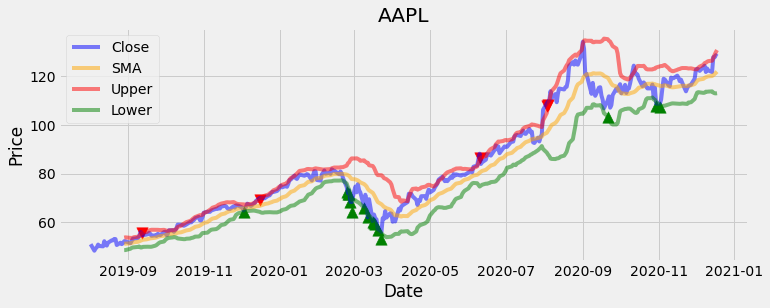

AAPL Performance
         Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0  64.072502  69.245003      5.172501   8.072887        5.172501
1  72.307503  86.522499     14.214996  19.659089       19.387497

Total Profit: $ 19.39
Total ROI: 14.22 %
Estimated Yearly ROI: 7.11 %
POOR Performance: Annual Alpha = -2.89 %


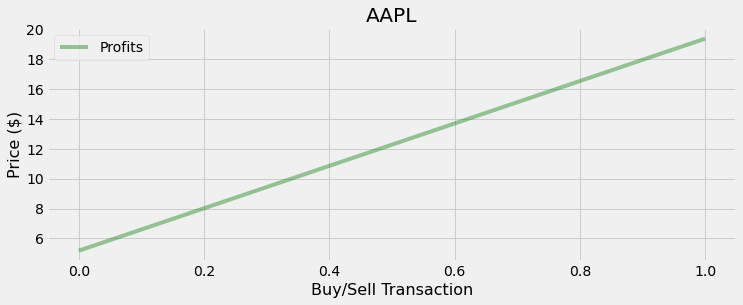

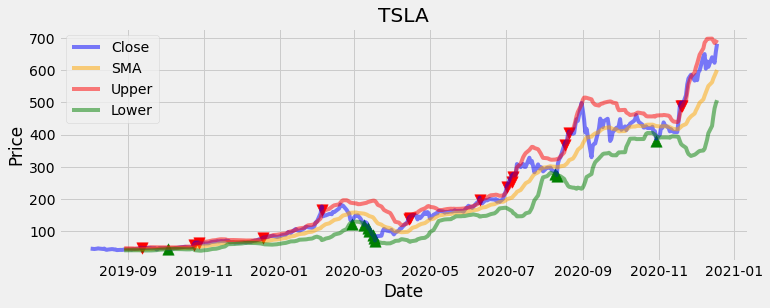

TSLA Performance
          Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   44.855999   57.840000     12.984001  28.945964       12.984001
1  122.304001  138.485992     16.181992  13.230958       29.165993
2  277.167999  369.022003     91.854004  33.140191      121.019997

Total Profit: $ 121.02
Total ROI: 27.24 %
Estimated Yearly ROI: 13.62 %
DECENT Performance: Annual Alpha = 3.62 %


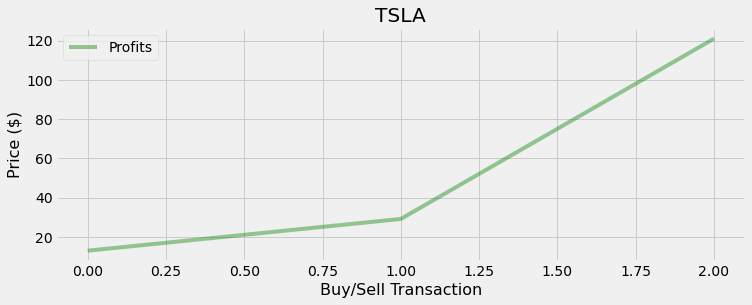

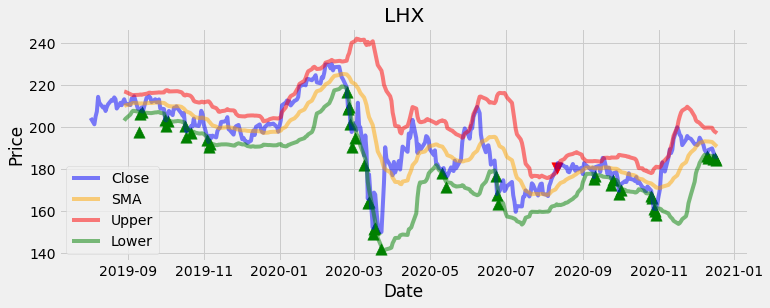

LHX Performance
          Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0  197.509995  180.580002    -16.929993  -8.571714      -16.929993

Total Profit: $ -16.93
Total ROI: -8.57 %
Estimated Yearly ROI: -4.29 %
POOR Performance: Annual Alpha = -14.29 %


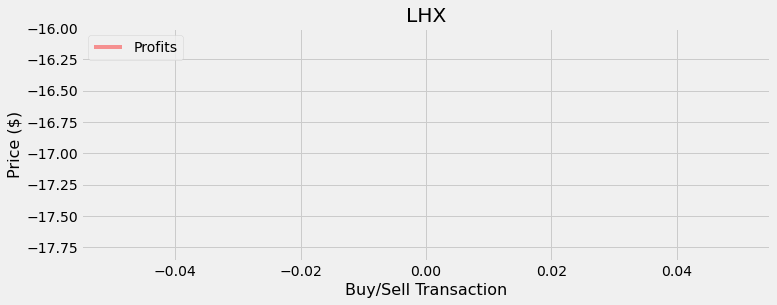

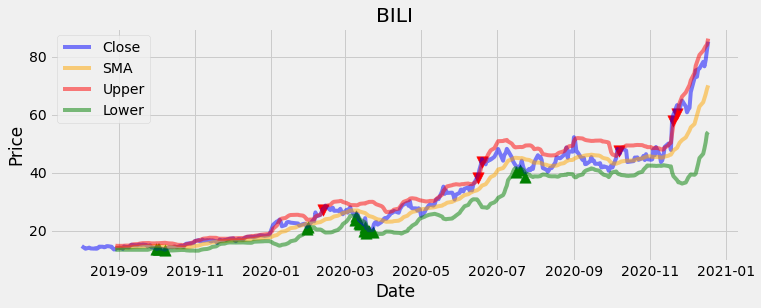

BILI Performance
         Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0  13.740000  27.059999     13.320000  96.943231       13.320000
1  23.700001  38.330002     14.630001  61.729960       27.950001
2  40.380001  47.470001      7.090000  17.558197       35.040001

Total Profit: $ 35.04
Total ROI: 45.03 %
Estimated Yearly ROI: 22.51 %
GREAT Performance: Annual Alpha = 12.51 %


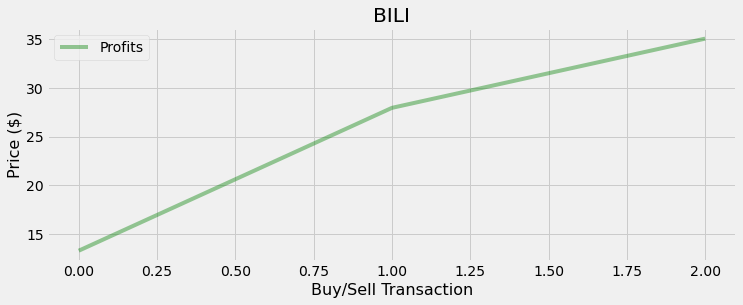

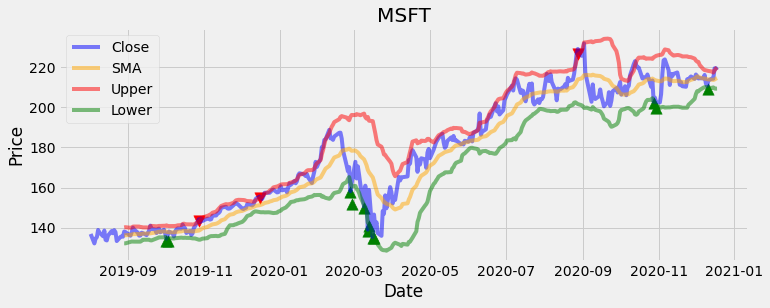

MSFT Performance
          Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0  133.580002  143.509995      9.929993   7.433742        9.929993
1  157.979996  226.580002     68.600006  43.423223       78.529999

Total Profit: $ 78.53
Total ROI: 26.93 %
Estimated Yearly ROI: 13.47 %
DECENT Performance: Annual Alpha = 3.47 %


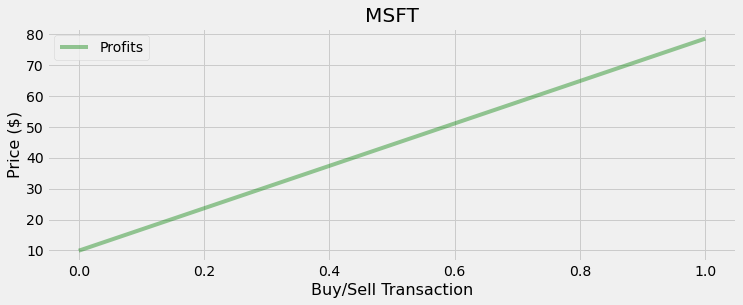

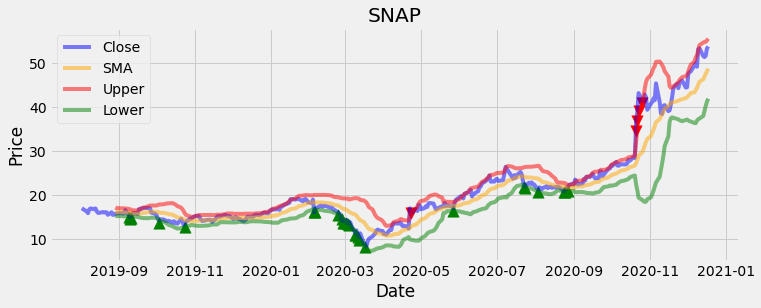

SNAP Performance
      Buy       Sell  Trade Profit   Trade ROI  Profit Balance
0  15.155  16.030001      0.875001    5.773678        0.875001
1  16.510  34.520000     18.010000  109.085403       18.885001

Total Profit: $ 18.89
Total ROI: 59.64 %
Estimated Yearly ROI: 29.82 %
GREAT Performance: Annual Alpha = 19.82 %


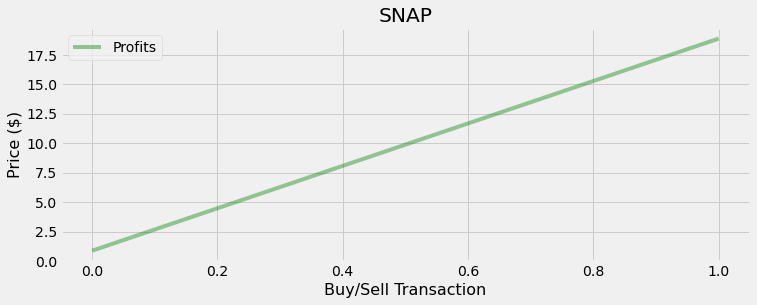

In [15]:
#Bollinger Band Strategy to determine when to buy and sell stock
#Creat a function to get the buy and sell signals
def get_Bollinger_signal(data):
    buy_signal = []
    sell_signal = []
    df= data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    #print("DATA IN FUNCTION\n",df, '\n', df.iloc[:,1])
    
    for i in range(0,len(data)):
        if data.iloc[i,1] > data.iloc[i,8]:
            buy_signal.append(np.nan)
            sell_signal.append(data.iloc[i,1])
        #If the closing price passes the lower band, the buy
        elif data.iloc[i,1] < data.iloc[i,9]:
            sell_signal.append(np.nan)
            buy_signal.append(data.iloc[i,1])
        #If the closing price does not pass any bands, then do nothing
        else:
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    return buy_signal, sell_signal


def calculate_Bollinger_Bands(ticker, plot=True):
    #Gather data
    stocks_df= web.DataReader(ticker, data_source='yahoo', start=two_years_ago)
    #print("\nStocks Dataframe\n",stocks_df)

    #Calculate Simple Moving Average (SMA)
    period = 20
    stocks_df['SMA'] = stocks_df['Close'].rolling(window=period).mean()

    #Calculate standard deviation
    stocks_df['STD']= stocks_df['Close'].rolling(window=period).std()

    #Calculate the upper Bollinger band
    stocks_df['Upper']= stocks_df['SMA'] + (stocks_df['STD'] *2)

    #Calculate the upper Bollinger band
    stocks_df['Lower']= stocks_df['SMA'] - (stocks_df['STD'] *2)

    #Determine when to buy and sell
    stocks_df['Buy'] = get_Bollinger_signal(stocks_df)[0]
    stocks_df['Sell'] = get_Bollinger_signal(stocks_df)[1]

    #Plot the data with indicators
    if plot==True:
        plt.figure(figsize= (11,4))
        plt.plot(stocks_df['Close'], color='blue', alpha=0.5)
        plt.plot(stocks_df['SMA'], color='orange', alpha=0.5)
        plt.plot(stocks_df['Upper'], color='red', alpha=0.5)
        plt.plot(stocks_df['Lower'], color='green', alpha=0.5)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.title(ticker)
        plt.ylabel('Price')
        plt.xlabel('Date')
        plt.legend(['Close', 'SMA', 'Upper','Lower'])
        plt.show()
    
    return stocks_df

for t in ticker:
    stock_information=calculate_Bollinger_Bands(t,plot=True)
    stocks_performance, analysis_profit, analysis_ROI= performance_analysis(stock_information, t, plot=True)
    #print(stock_information)
            

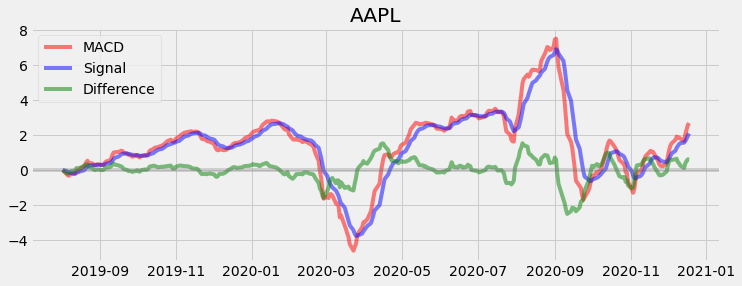

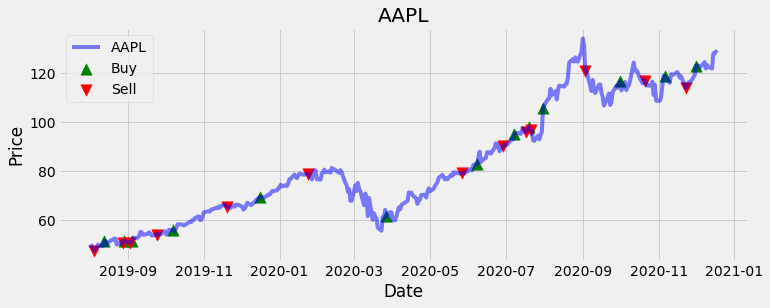

AAPL Performance
           Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0    51.640156   50.790073     -0.850082  -1.646165       -0.850082
1    51.650040   50.832081     -0.817959  -1.583656       -1.668041
2    51.694523   53.792549      2.098026   4.058508        0.429985
3    56.110516   65.234146      9.123631  16.260108        9.553616
4    69.365952   78.896149      9.530197  13.739013       19.083813
5    61.550438   79.247643     17.697205  28.752362       36.781017
6    83.071640   90.126732      7.055092   8.492780       43.836109
7    95.006996   95.988533      0.981537   1.033121       44.817646
8    98.011391   96.658661     -1.352730  -1.380176       43.464916
9   105.886086  120.671806     14.785721  13.963800       58.250637
10  116.588860  116.668724      0.079865   0.068501       58.330502
11  118.690002  113.849998     -4.840004  -4.077853       53.490498

Total Profit: $ 53.49
Total ROI: 5.58 %
Estimated Yearly ROI: 2.79 %
POOR Performance: Annual Alph

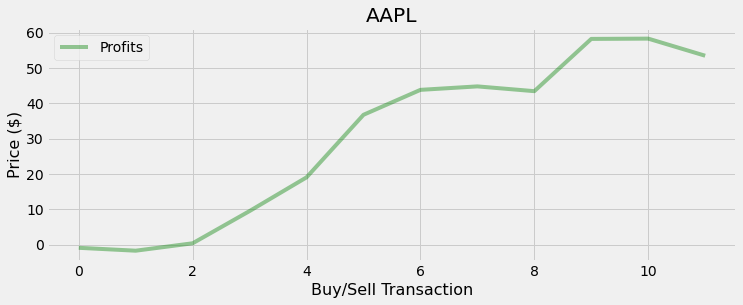

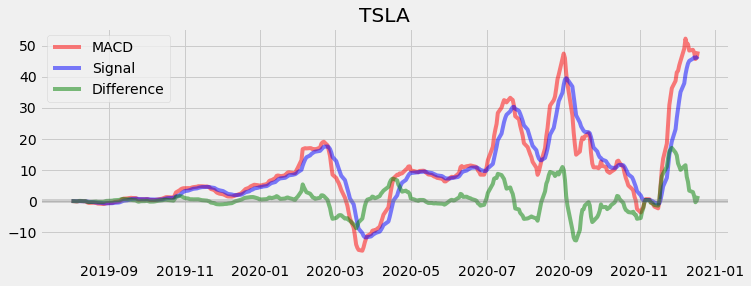

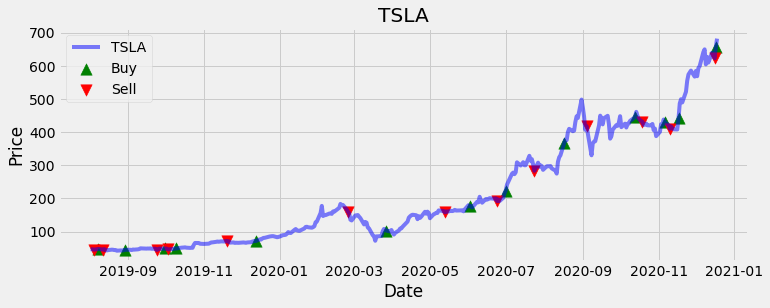

TSLA Performance
           Buy        Sell  Trade Profit   Trade ROI  Profit Balance
0    47.660000   45.801998     -1.858002   -3.898451       -1.858002
1    45.122002   44.641998     -0.480003   -1.063790       -2.338005
2    48.938000   46.605999     -2.332001   -4.765215       -4.670006
3    48.948002   70.444000     21.495998   43.915988       16.825993
4    71.678001  159.981995     88.303993  123.195390      105.129986
5   102.872002  158.192001     55.320000   53.775565      160.449986
6   176.311996  192.169998     15.858002    8.994284      176.307987
7   223.925995  283.399994     59.473999   26.559667      235.781986
8   367.127991  418.320007     51.192017   13.943915      286.974003
9   446.649994  430.829987    -15.820007   -3.541925      271.153996
10  429.950012  410.359985    -19.590027   -4.556350      251.563969
11  441.609985  622.770020    181.160034   41.022631      432.724003

Total Profit: $ 432.72
Total ROI: 17.66 %
Estimated Yearly ROI: 8.83 %
POOR Performan

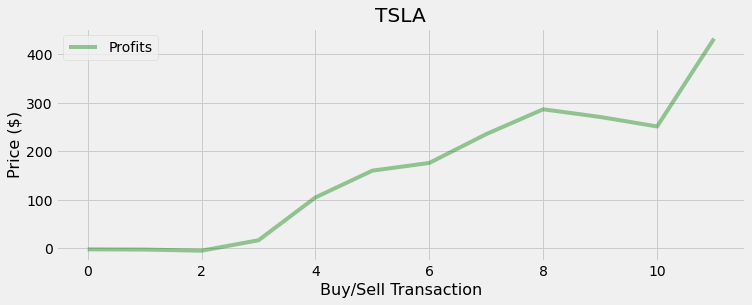

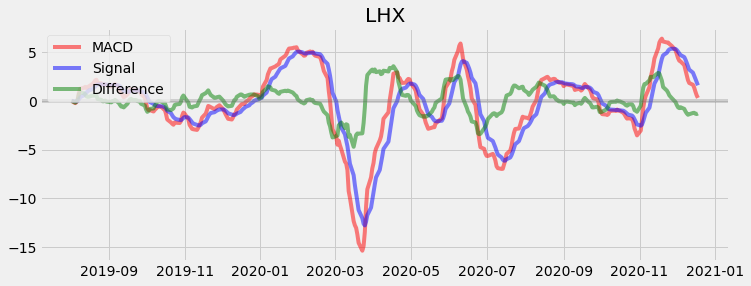

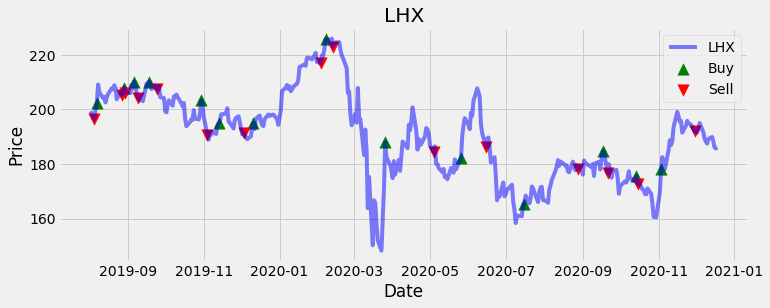

LHX Performance
           Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   202.329117  205.274399      2.945282   1.455689        2.945282
1   208.024673  206.181412     -1.843262  -0.886078        1.102020
2   210.135529  204.380539     -5.754990  -2.738704       -4.652969
3   210.135529  207.404846     -2.730682  -1.299486       -7.383652
4   203.401825  190.785812    -12.616013  -6.202507      -19.999664
5   194.994431  191.496872     -3.497559  -1.793671      -23.497223
6   194.974335  216.988525     22.014191  11.290815       -1.483032
7   225.800095  223.000427     -2.799667  -1.239888       -4.282700
8   187.983597  184.352219     -3.631378  -1.931753       -7.914078
9   182.329269  186.409729      4.080460   2.237962       -3.833618
10  165.529053  178.273499     12.744446   7.699220        8.910828
11  184.637222  176.811249     -7.825974  -4.238568        1.084854
12  175.586578  172.719040     -2.867538  -1.633119       -1.782684

Total Profit: $ -1.78
Total ROI

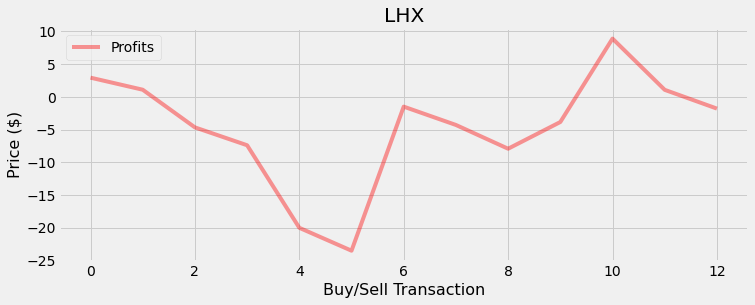

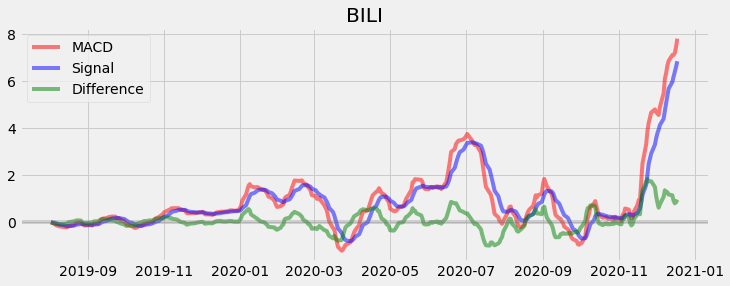

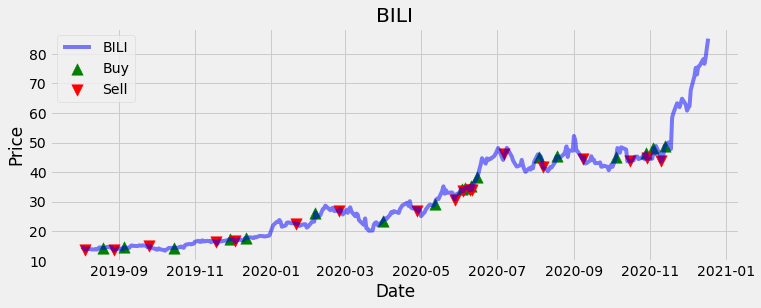

BILI Performance
          Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0   14.500000  13.530000     -0.970000  -6.689657       -0.970000
1   14.590000  14.890000      0.300000   2.056204       -0.670000
2   14.510000  16.379999      1.869999  12.887656        1.199999
3   17.280001  16.680000     -0.600000  -3.472224        0.599998
4   17.740000  22.610001      4.870001  27.452091        5.469999
5   26.340000  26.719999      0.379999   1.442670        5.849998
6   23.420000  26.959999      3.539999  15.115282        9.389997
7   29.240000  30.740000      1.500000   5.129959       10.889997
8   34.150002  33.560001     -0.590000  -1.727672       10.299997
9   34.500000  33.869999     -0.630001  -1.826090        9.669996
10  35.480000  33.900002     -1.579998  -4.453208        8.089998
11  38.209999  46.230000      8.020000  20.989272       16.109999
12  45.189999  41.610001     -3.579998  -7.922103       12.530001
13  45.310001  44.389999     -0.920002  -2.030461       11.

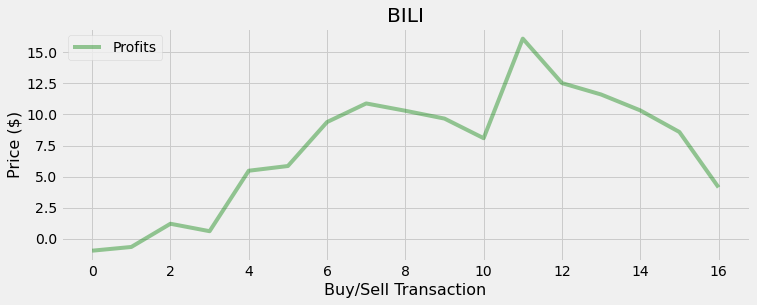

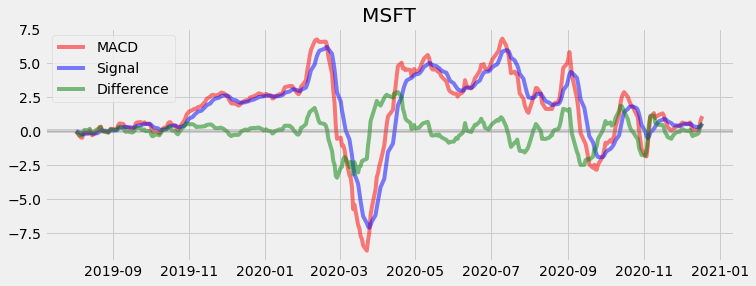

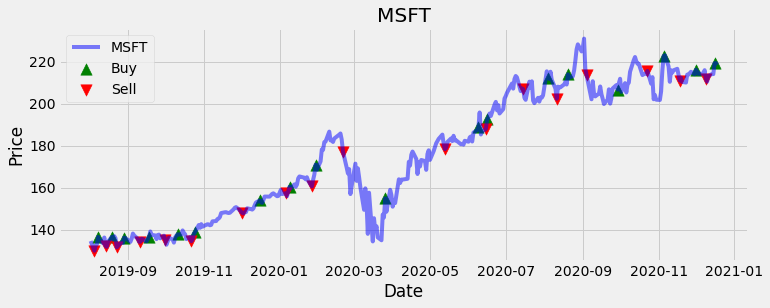

MSFT Performance
           Buy        Sell  Trade Profit  Trade ROI  Profit Balance
0   136.513412  132.125946     -4.387466  -3.213945       -4.387466
1   136.494659  131.544113     -4.950546  -3.626916       -9.338013
2   136.208664  134.236328     -1.972336  -1.448025      -11.310349
3   136.603134  135.173218     -1.429916  -1.046767      -12.740265
4   137.747070  134.482895     -3.264175  -2.369688      -16.004440
5   138.782547  147.982330      9.199783   6.628920       -6.804657
6   153.899643  157.362961      3.463318   2.250374       -3.341339
7   160.390869  160.578888      0.188019   0.117225       -3.153320
8   170.968826  177.200607      6.231781   3.644981        3.078461
9   154.895493  178.351578     23.456085  15.143168       26.534546
10  188.847900  187.992203     -0.855698  -0.453115       25.678848
11  192.598984  206.996368     14.397385   7.475317       40.076233
12  212.220047  202.359772     -9.860275  -4.646251       30.215958
13  214.019684  213.690552     

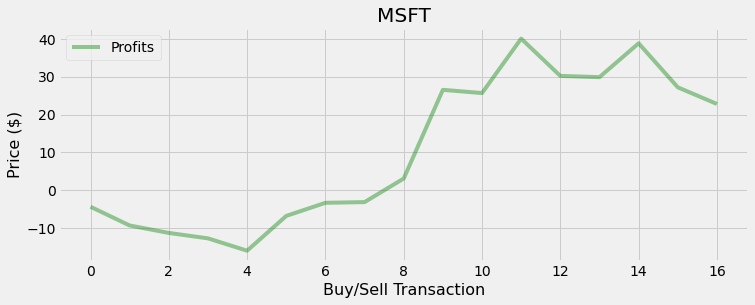

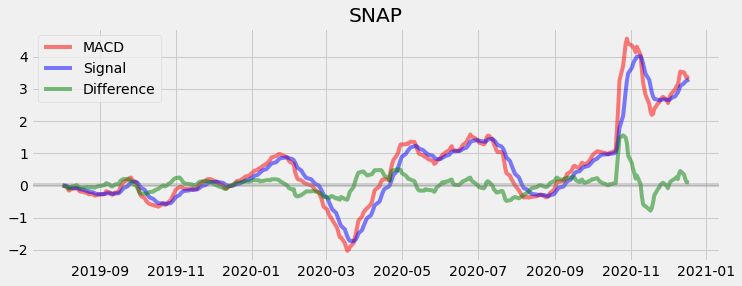

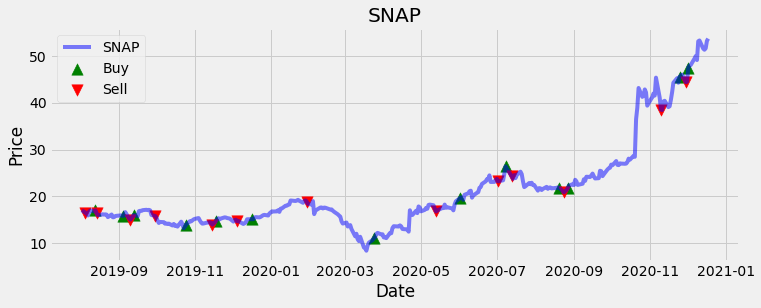

SNAP Performance
          Buy       Sell  Trade Profit  Trade ROI  Profit Balance
0   17.000000  16.360001     -0.639999  -3.764702       -0.639999
1   15.800000  15.020000     -0.780000  -4.936707       -1.419999
2   16.000000  15.800000     -0.200000  -1.249999       -1.619999
3   13.960000  13.940000     -0.020000  -0.143270       -1.639999
4   14.690000  14.680000     -0.009999  -0.068069       -1.649999
5   15.100000  18.879999      3.779999  25.033104        2.130000
6   11.000000  16.770000      5.770000  52.454550        7.900001
7   19.549999  23.219999      3.670000  18.772380       11.570001
8   26.410000  24.270000     -2.139999  -8.102989        9.430001
9   21.830000  20.870001     -0.959999  -4.397614        8.470002
10  21.740000  38.540001     16.800001  77.276915       25.270003
11  45.560001  44.419998     -1.140003  -2.502202       24.130000

Total Profit: $ 24.13
Total ROI: 10.11 %
Estimated Yearly ROI: 5.06 %
POOR Performance: Annual Alpha = -4.94 %


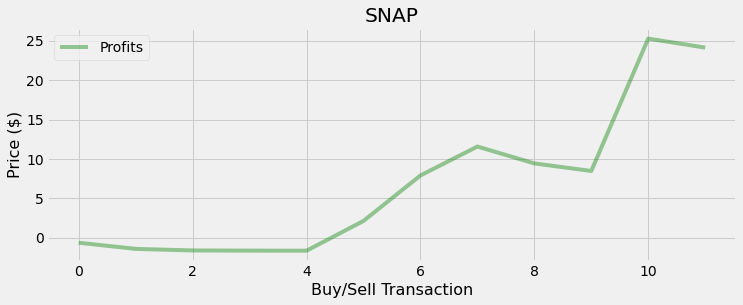

In [16]:
#Function to determine when to buy and sell stocks using MACD analysis
def get_MACD_signal(signal):
    Buy = []
    Sell =[]
    flag = -1
    
    for i in range(0, len(signal)):
        
        #If MACD line crosses the signal line, then buy
        if signal.iloc[i,1] > signal.iloc[i,2]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal.iloc[i,0])
                flag = 1
            else:
                Buy.append(np.nan)
                
        #If signal line crosses the MACD line, then sell
        elif signal.iloc[i,1] < signal.iloc[i,2]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal.iloc[i,0])
                flag = 0
            else:
                Sell.append(np.nan)
        
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return Buy,Sell

#Calculate the MACD and signal line indicators
def calculate_MACD(ticker, plot=True):
    stocks_df = import_stock_data(ticker, two_years_ago, today)

    ShortEMA = 0
    MiddleEMA = 0
    LongEMA = 0
    #Short/Fast Exponential Moving Average (12 Day EMA)
    ShortEMA = stocks_df.ewm(span=12, adjust=False).mean()

    #Long/Slow Exponential Moving Average (26 Day EMA)
    LongEMA = stocks_df.ewm(span=26, adjust = False).mean()

    #Calculate the MACD
    MACD = ShortEMA - LongEMA

    #Calculate the signal line
    signal = MACD.ewm(span=9, adjust=False).mean()

    #Calculate difference between MACD and Signal
    difference = MACD - signal

    #difference_list = []
    #for i in range(0,len(difference)):
        #difference_list.append(difference.iloc[i,0])

    #print(difference_list)
    #print(difference)
    #plt.bar(stocks_df.index, height=difference)

    #x = np.arange(0,len(stocks_df), 1)
    #print(x)

    #Plot the chart
    if plot==True:
        
        plt.figure(figsize=(11,4))
        plt.plot(stocks_df.index, MACD, label= 'MACD', color= 'red', alpha=0.5)
        plt.plot(stocks_df.index, signal, label= 'Signal', color= 'blue', alpha=0.5)
        plt.plot(stocks_df.index, difference,label='Difference', color = "green", alpha=0.5)
        plt.axhline(0, linestyle= '-', color = 'gray', alpha=0.3)
        #plt.fill_between(x,difference_list,0)
        plt.title(ticker)
        plt.legend(loc='upper left')
        plt.show()

        #Create MACD and Signal Line Columns
        stocks_df['MACD'] = MACD
        stocks_df['Signal Line'] = signal
        stocks_df['Difference']= difference

        #Create buy and sell columns
        stocks_df['Buy'], stocks_df['Sell'] = get_MACD_signal(stocks_df)
        #stocks_df

        #Plot the buy and sell signals
        plt.figure(figsize= (11,4))
        plt.plot(stocks_df[ticker], color='blue', alpha=0.5)
        #plt.plot(stocks_df['MACD'], color='orange', alpha=0.5)
        #plt.plot(stocks_df['Signal Line'], color='red', alpha=0.5)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.title(ticker)
        plt.ylabel('Price')
        plt.xlabel('Date')
        plt.legend([ticker,'Buy','Sell'])
        plt.show()

        return stocks_df

for t in ticker:
    stock_information=calculate_MACD(t,plot=True)
    stocks_performance, analysis_profit, analysis_ROI= performance_analysis(stock_information, t, plot=True)
    #print(stock_information)
